Loaded: C:\Users\abhin\Downloads\Data Trasformation (2)\adult_with_headers (1).csv shape: (32561, 15)


,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K



Columns, dtypes and uniques:


,dtype,n_unique
age,int64,73
workclass,object,8
fnlwgt,int64,21648
education,object,16
education_num,int64,16
marital_status,object,7
occupation,object,14
relationship,object,6
race,object,5
sex,object,2



Missing counts (raw):


age                  0
workclass         1836
fnlwgt               0
education            0
education_num        0
marital_status       0
occupation        1843
relationship         0
race                 0
sex                  0
capital_gain         0
capital_loss         0
hours_per_week       0
native_country     583
income               0
dtype: int64

Detected target: income

Numeric cols: ['age', 'fnlwgt', 'education_num', 'capital_gain', 'capital_loss', 'hours_per_week']
Categorical cols: ['workclass', 'education', 'marital_status', 'occupation', 'relationship', 'race', 'sex', 'native_country', 'income']
Outliers detected (count): 652
capital_gain skew before: 11.954
capital_gain_log skew after: 3.096


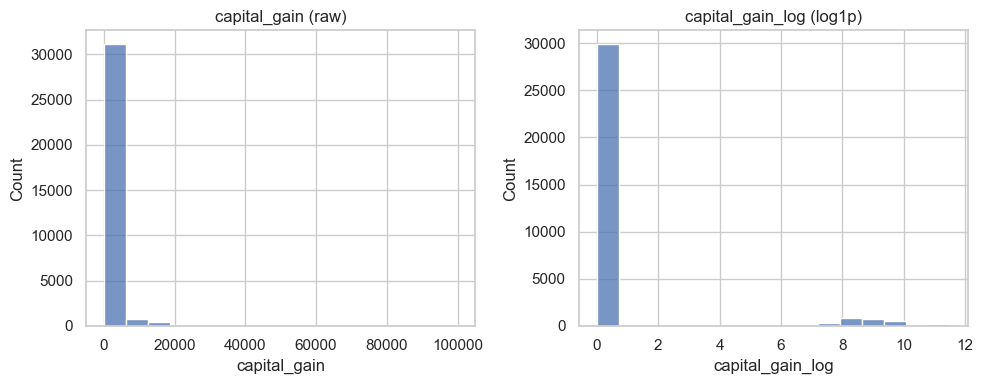


Missing counts before imputation (selected cols):


age                            0
fnlwgt                         0
education_num                  0
capital_gain                   0
capital_loss                   0
hours_per_week                 0
capital_net                    0
work_hours_per_education       0
capital_gain_log               0
workclass                   1836
education                      0
marital_status                 0
occupation                  1843
relationship                   0
race                           0
sex                            0
native_country               583
income                         0
dtype: int64


Missing counts after demo imputation (should be 0):


age                         0
fnlwgt                      0
education_num               0
capital_gain                0
capital_loss                0
hours_per_week              0
capital_net                 0
work_hours_per_education    0
capital_gain_log            0
workclass                   0
education                   0
marital_status              0
occupation                  0
relationship                0
race                        0
sex                         0
native_country              0
income                      0
dtype: int64


Encoding strategy: {'workclass': 'label', 'education': 'label', 'marital_status': 'label', 'occupation': 'label', 'relationship': 'label', 'race': 'onehot', 'sex': 'onehot', 'native_country': 'label', 'income': 'onehot'}

Columns to scale: ['age', 'fnlwgt', 'education_num', 'capital_gain', 'capital_loss', 'hours_per_week', 'capital_net', 'work_hours_per_education', 'capital_gain_log']

Target not found - skipping RandomForest importance demo.
PPS not installed; skipping PPS analysis. Install with: pip install ppscore

Saved: adult_transformed_ohe.csv, adult_transformed_std.csv, adult_transformed_minmax.csv
Saved scalers and encoders: adult_std_scaler.joblib, adult_mm_scaler.joblib, label_encoders.joblib

Feature engineering:
- capital_net = capital_gain - capital_loss : Captures net capital effect on income.
- work_hours_per_education = hours_per_week / (education_num + 1) : Interaction approximating productivity.
- high_capital (binary) : flags presence of capital gains.

Transform:


In [4]:
# =========================
# Data Transformation & Feature Engineering — Adult dataset
# Path (your local file):
# C:\Users\abhin\Downloads\Data Trasformation (2)\adult_with_headers (1).csv
# =========================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import IsolationForest, RandomForestClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
import joblib
import warnings
warnings.filterwarnings('ignore')
sns.set(style='whitegrid')

# -------------------------
# 0) Settings - update path if needed
# -------------------------
DATA_PATH = r"C:\Users\abhin\Downloads\Data Trasformation (2)\adult_with_headers (1).csv"

# -------------------------
# 1) Load dataset
# -------------------------
df = pd.read_csv(DATA_PATH, header=0, na_values=['?', ' ?', 'NA', 'nan', ''])
print("Loaded:", DATA_PATH, "shape:", df.shape)
display(df.head())

# -------------------------
# 2) Basic exploration
# -------------------------
print("\nColumns, dtypes and uniques:")
display(pd.DataFrame({'dtype': df.dtypes, 'n_unique': df.nunique()}))

print("\nMissing counts (raw):")
display(df.isna().sum())

# Normalize column names
df.columns = [c.strip().replace('-', '_').replace(' ', '_') for c in df.columns]

# Try to detect common target names
target_col = None
for t in ['income', 'Income', 'label', 'target']:
    if t in df.columns:
        target_col = t
        break
print("Detected target:", target_col)

# -------------------------
# 3) Identify numeric & categorical columns
# -------------------------
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
if target_col in numeric_cols:
    numeric_cols.remove(target_col)
categorical_cols = df.select_dtypes(include=['object','category']).columns.tolist()
print("\nNumeric cols:", numeric_cols)
print("Categorical cols:", categorical_cols)

# -------------------------
# 4) Treat common zero-as-missing for Adult dataset if present
# -------------------------
# Adult dataset does not typically have zero-as-missing like PIMA, but keep logic flexible:
zero_as_missing_candidates = ['capital_gain','capital_loss','hours_per_week','age','fnlwgt']
for c in zero_as_missing_candidates:
    if c in df.columns:
        # do not blindly replace 0 for all columns; only if there are suspicious zeros proportion
        zero_pct = (df[c] == 0).mean() * 100
        if zero_pct > 0 and zero_pct < 90:  # only consider replacing if non-trivial but not almost-all zeros
            # leave as-is; Adult zeros are valid for many cols; user can adjust this block if needed
            pass

# -------------------------
# 5) Outlier detection with IsolationForest (mark only)
# -------------------------
if numeric_cols:
    iso = IsolationForest(n_estimators=200, contamination=0.02, random_state=42)
    try:
        iso.fit(df[numeric_cols].fillna(df[numeric_cols].median()))
        outlier_flag = iso.predict(df[numeric_cols].fillna(df[numeric_cols].median()))
        df['is_outlier_iforest'] = (outlier_flag == -1).astype(int)
        print("Outliers detected (count):", df['is_outlier_iforest'].sum())
    except Exception as e:
        print("IsolationForest failed:", e)
        df['is_outlier_iforest'] = 0
else:
    df['is_outlier_iforest'] = 0

# -------------------------
# 6) Feature engineering - create at least 2 new features (with rationale)
# -------------------------
# Feature A: capital_net = capital_gain - capital_loss
if 'capital_gain' in df.columns:
    df['capital_gain'] = pd.to_numeric(df['capital_gain'], errors='coerce').fillna(0)
if 'capital_loss' in df.columns:
    df['capital_loss'] = pd.to_numeric(df['capital_loss'], errors='coerce').fillna(0)
if 'capital_gain' in df.columns or 'capital_loss' in df.columns:
    df['capital_net'] = df.get('capital_gain', 0) - df.get('capital_loss', 0)
else:
    df['capital_net'] = 0

# Rationale: net capital better summarizes wealth effect than separate fields.

# Feature B: work_hours_per_education = hours_per_week / (education_num + 1)
if 'hours_per_week' in df.columns:
    df['hours_per_week'] = pd.to_numeric(df['hours_per_week'], errors='coerce')
if 'education_num' in df.columns:
    df['education_num'] = pd.to_numeric(df['education_num'], errors='coerce')
if 'hours_per_week' in df.columns:
    df['work_hours_per_education'] = df['hours_per_week'] / (df.get('education_num', 0).replace(0, np.nan).fillna(1))
else:
    df['work_hours_per_education'] = 0

# Rationale: interaction approximates productivity adjusted by education level.

# Extra small useful feature: high_capital flag
df['high_capital'] = (df.get('capital_gain', 0) > 0).astype(int)

# -------------------------
# 7) Log-transform at least one skewed numerical feature (capital_gain)
# -------------------------
if 'capital_gain' in df.columns:
    before_skew = df['capital_gain'].dropna().skew()
    print(f"capital_gain skew before: {before_skew:.3f}")
    df['capital_gain_log'] = np.log1p(df['capital_gain'].fillna(0))
    after_skew = df['capital_gain_log'].dropna().skew()
    print(f"capital_gain_log skew after: {after_skew:.3f}")

    # Optional plot (comment out if running non-interactively)
    try:
        fig, ax = plt.subplots(1,2, figsize=(10,4))
        sns.histplot(df['capital_gain'].dropna(), ax=ax[0], kde=False).set_title('capital_gain (raw)')
        sns.histplot(df['capital_gain_log'].dropna(), ax=ax[1], kde=False).set_title('capital_gain_log (log1p)')
        plt.tight_layout()
        plt.show()
    except Exception:
        pass

# -------------------------
# 8) Missing value handling demonstration (median for numerics, mode for categoricals)
# -------------------------
num_impute_cols = [c for c in numeric_cols if c in df.columns] + ['capital_net', 'work_hours_per_education', 'capital_gain_log']
num_impute_cols = [c for c in num_impute_cols if c in df.columns]
cat_impute_cols = [c for c in categorical_cols if c in df.columns]

print("\nMissing counts before imputation (selected cols):")
display(df[num_impute_cols + cat_impute_cols].isna().sum())

# create a demo-imputed dataframe (for inspection / saving)
df_demo = df.copy()
for c in num_impute_cols:
    df_demo[c] = df_demo[c].fillna(df_demo[c].median())
for c in cat_impute_cols:
    if not df_demo[c].mode().empty:
        df_demo[c] = df_demo[c].fillna(df_demo[c].mode().iloc[0])
    else:
        df_demo[c] = df_demo[c].fillna('missing')

print("\nMissing counts after demo imputation (should be 0):")
display(df_demo[num_impute_cols + cat_impute_cols].isna().sum())

# -------------------------
# 9) Encoding: One-Hot for low cardinality (<5), Label for high cardinality (>=5)
# -------------------------
one_hot_cols = []
label_cols = []
encoding_map = {}
for c in cat_impute_cols:
    nuni = df_demo[c].nunique(dropna=True)
    if nuni <= 5:
        one_hot_cols.append(c)
        encoding_map[c] = 'onehot'
    else:
        label_cols.append(c)
        encoding_map[c] = 'label'
print("\nEncoding strategy:", encoding_map)

# Apply Label Encoding for high-cardinality
label_encoders = {}
for c in label_cols:
    le = LabelEncoder()
    df_demo[c] = df_demo[c].astype(str)
    try:
        df_demo[c] = le.fit_transform(df_demo[c])
        label_encoders[c] = le
    except Exception as e:
        print("LabelEncoder failed for", c, e)

# Apply One-Hot Encoding (create df_ohe)
df_ohe = pd.get_dummies(df_demo, columns=one_hot_cols, drop_first=True)

# -------------------------
# 10) Scaling: produce both Standard and MinMax scaled versions for numeric features
# -------------------------
scale_cols = [c for c in num_impute_cols if c in df_ohe.columns]
print("\nColumns to scale:", scale_cols)

std_scaler = StandardScaler()
mm_scaler = MinMaxScaler()

df_std = df_ohe.copy()
df_mm = df_ohe.copy()

if scale_cols:
    df_std[scale_cols] = std_scaler.fit_transform(df_std[scale_cols])
    df_mm[scale_cols] = mm_scaler.fit_transform(df_mm[scale_cols])

# Save scalers
joblib.dump(std_scaler, 'adult_std_scaler.joblib')
joblib.dump(mm_scaler, 'adult_mm_scaler.joblib')

# -------------------------
# 11) Quick feature importance demo (optional) if target present
# -------------------------
if target_col and target_col in df_ohe.columns:
    X_feat = df_ohe.drop(columns=[target_col]).fillna(0)
    y_feat = df_ohe[target_col].astype(int)
    rf = RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1)
    rf.fit(X_feat, y_feat)
    importances = pd.Series(rf.feature_importances_, index=X_feat.columns).sort_values(ascending=False)
    print("\nTop 15 feature importances (RandomForest):")
    display(importances.head(15))
else:
    print("\nTarget not found - skipping RandomForest importance demo.")

# -------------------------
# 12) (Optional) PPS analysis if ppscore installed
# -------------------------
try:
    import ppscore as pps
    if target_col and target_col in df_ohe.columns:
        pps_res = pps.predictors(df_ohe.fillna(0), target_col)
        print("\nPPS top predictors:")
        display(pps_res.sort_values('ppscore', ascending=False).head(10))
    else:
        print("PPS: target not found; skipping.")
except Exception:
    print("PPS not installed; skipping PPS analysis. Install with: pip install ppscore")

# -------------------------
# 13) Save final outputs ready for submission
# -------------------------
df_ohe.to_csv('adult_transformed_ohe.csv', index=False)
df_std.to_csv('adult_transformed_std.csv', index=False)
df_mm.to_csv('adult_transformed_minmax.csv', index=False)
joblib.dump(label_encoders, 'label_encoders.joblib')

print("\nSaved: adult_transformed_ohe.csv, adult_transformed_std.csv, adult_transformed_minmax.csv")
print("Saved scalers and encoders: adult_std_scaler.joblib, adult_mm_scaler.joblib, label_encoders.joblib")

# -------------------------
# 14) Short rationale to paste in notebook (string)
# -------------------------
rationale = """
Feature engineering:
- capital_net = capital_gain - capital_loss : Captures net capital effect on income.
- work_hours_per_education = hours_per_week / (education_num + 1) : Interaction approximating productivity.
- high_capital (binary) : flags presence of capital gains.

Transform:
- Applied log1p to capital_gain to reduce skew and stabilize variance.

Encoding:
- One-Hot for categorical vars with <=5 unique values to avoid imposing order.
- Label encoding for high-cardinality categorical vars to keep dimensionality manageable.

Scaling:
- Saved both StandardScaler and MinMaxScaler versions. Use Standard for linear models/PCA; MinMax for NN or algorithms needing [0,1].
"""
print(rationale)
